#### In This Part :
- **Neural Network Models for Geophysical Predictions** : We used gaussian process neural network model designed to simulate geophysical properties such as density and wave velocities from depth data. This model utilizes advanced techniques like radial basis function (RBF) kernels and inducing points to capture complex patterns in the data.
- **Visualization and Interpretation** : The models provide visualization tools to illustrate predicted geophysical properties, such as density distributions and wave ray paths. These visualizations help in understanding the spatial distribution of properties and identifying regions like shadow zones where waves are not detected.

In [6]:
import torch
import torch.nn as nn
import torch_optimizer as optim
from torch.optim import lr_scheduler
import numpy as np
import csv
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

RADIUS = 3389500.0
MANTLE_CRUST = 3313846.9
CORE_MANTLE = 1780745.3
MODULI_PARAMS = {
   "core": {"K": 150e9, "mu": 50e9, "depth": CORE_MANTLE},
   "mantle": {"K": 100e9, "mu": 40e9, "depth": MANTLE_CRUST},
   "crust": {"K": 80e9, "mu": 30e9, "depth": RADIUS}
}

#### We first find a mapping fucntion for density to depth so that we can use it further for calculating P and S wave velocity :
- The DensityGPNN (Gaussian Process Neural Network) neural network is designed to predict density from depth data using a combination of deep learning techniques, including a radial basis function (RBF) kernel and inducing points, and provides visualization tools to compare predicted and actual density distributions.

In [3]:
class DensityGPNN(nn.Module):
    def __init__(self, hidden_dim=128, num_inducing=16):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_inducing = num_inducing
        self.depth_norm = 3.5e6
        self.density_norm = 1e4
    
        self.network = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )
        self.inducing_points = nn.Parameter(
            torch.linspace(0, 1, num_inducing).reshape(-1, 1)
        )
        self.rbf_network = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Softplus()
        )
        
        # Output network
        self.output_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Softplus()
        )
        
    def rbf_kernel(self, x, centers):
        x_expanded = x.unsqueeze(1)
        centers_expanded = centers.unsqueeze(0)
        pairs = torch.cat([
            x_expanded.expand(-1, centers.shape[0], -1),
            centers_expanded.expand(x.shape[0], -1, -1)
        ], dim=2)
        return self.rbf_network(pairs).squeeze(-1)
    
    def forward(self, depth):
        x = depth / self.depth_norm
        features = self.network(x) 
        kernel_values = self.rbf_kernel(x, self.inducing_points)
        weights = torch.softmax(kernel_values, dim=-1)
        inducing_features = self.network(self.inducing_points)
        combined = torch.matmul(weights, inducing_features)
        final_features = features + combined
        output = self.output_net(final_features) * self.density_norm
        return output
    
def prepare_data(filename):
    data = []
    with open(filename, 'r') as f:
        for line in f:
            if line.strip().startswith('COLUMNS'):
                break
        for line in f:
            if line[0].isdigit() or line[0].isspace():
                values = line.split()
                if len(values) >= 8:
                    radius = float(values[0])
                    rho = float(values[1])
                    vpv = float(values[2])
                    vsv = float(values[3])
                    data.append([radius, rho, vpv, vsv])

    data = np.array(data)
    depth = torch.tensor(data[:, 0], dtype=torch.float32).reshape(-1, 1)
    density = torch.tensor(data[:, 1], dtype=torch.float32).reshape(-1, 1)
    vp = torch.tensor(data[:, 2], dtype=torch.float32).reshape(-1, 1)
    vs = torch.tensor(data[:, 3], dtype=torch.float32).reshape(-1, 1)

    return depth, density, vp, vs
                    
def train_density_model(model, depth, density, epochs=5000):    
    optimizer = optim.Yogi(model.parameters(), lr=0.0008, betas=(0.9, 0.999), 
                          eps=1e-8, weight_decay=1e-5)
    scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=200, T_mult=2)
    criterion = nn.MSELoss()
    
    losses = []
    best_loss = float('inf')
    if len(depth.shape) == 1:
        depth = depth.reshape(-1, 1)
    if len(density.shape) == 1:
        density = density.reshape(-1, 1)
    
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        optimizer.zero_grad()
        pred_density = model(depth)
        loss = criterion(pred_density, density)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        current_loss = loss.item()
        losses.append(current_loss)
        pbar.set_description(f"Loss: {current_loss:.6f}")
        if current_loss < best_loss:
            best_loss = current_loss
            torch.save(model.state_dict(), r"module_9_data/density.pth")

    
    return model, losses

def load_density_model(model_path="density_model.pth"):
    model = DensityGPNN()
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def predict_and_visualize_density(density_model, depth, density):
    plt.figure(figsize=(20, 8))
    
    plt.subplot(1, 2, 1)
    plt.plot(depth.numpy(), density.numpy(), 'b.', label='Original Data')
    test_depths = torch.linspace(depth.min(), depth.max(), 1000).reshape(-1, 1)
    
    with torch.no_grad():
        pred_density = density_model(test_depths)
    
    plt.plot(test_depths.numpy(), pred_density.numpy(), 'r-', label='Predicted Density')
    plt.title('Density vs Depth')
    plt.xlabel('Depth (m)')
    plt.ylabel('Density (kg/m³)')
    plt.grid(True)
    plt.legend()
    
    n_radial = 500
    n_angular = 50
    
    theta = np.linspace(0, 2*np.pi, n_angular)
    r = np.linspace(0, 1, n_radial)
    R, Theta = np.meshgrid(r, theta)
    
    density_array = pred_density.numpy().flatten()
    
    density_polar = np.interp(np.linspace(0, 1, n_radial), 
                               np.linspace(0, 1, len(density_array)), 
                               density_array)
    
    density_2d = np.tile(density_polar, (n_angular, 1))
    
    plt.subplot(1, 2, 2, projection='polar')
    plt.pcolormesh(Theta, R, density_2d, cmap='YlOrRd')
    plt.title('Density Circular Cross-Section')
    plt.colorbar(label='Density (kg/m³)')
    
    plt.tight_layout()
    plt.show()

In [5]:
depth, density, vp, vs = prepare_data(r"module_9_data\BM FILES\DWAK.txt")

In [ ]:
density_model = DensityGPNN()
trained_density_model, losses = train_density_model(density_model, depth, density)

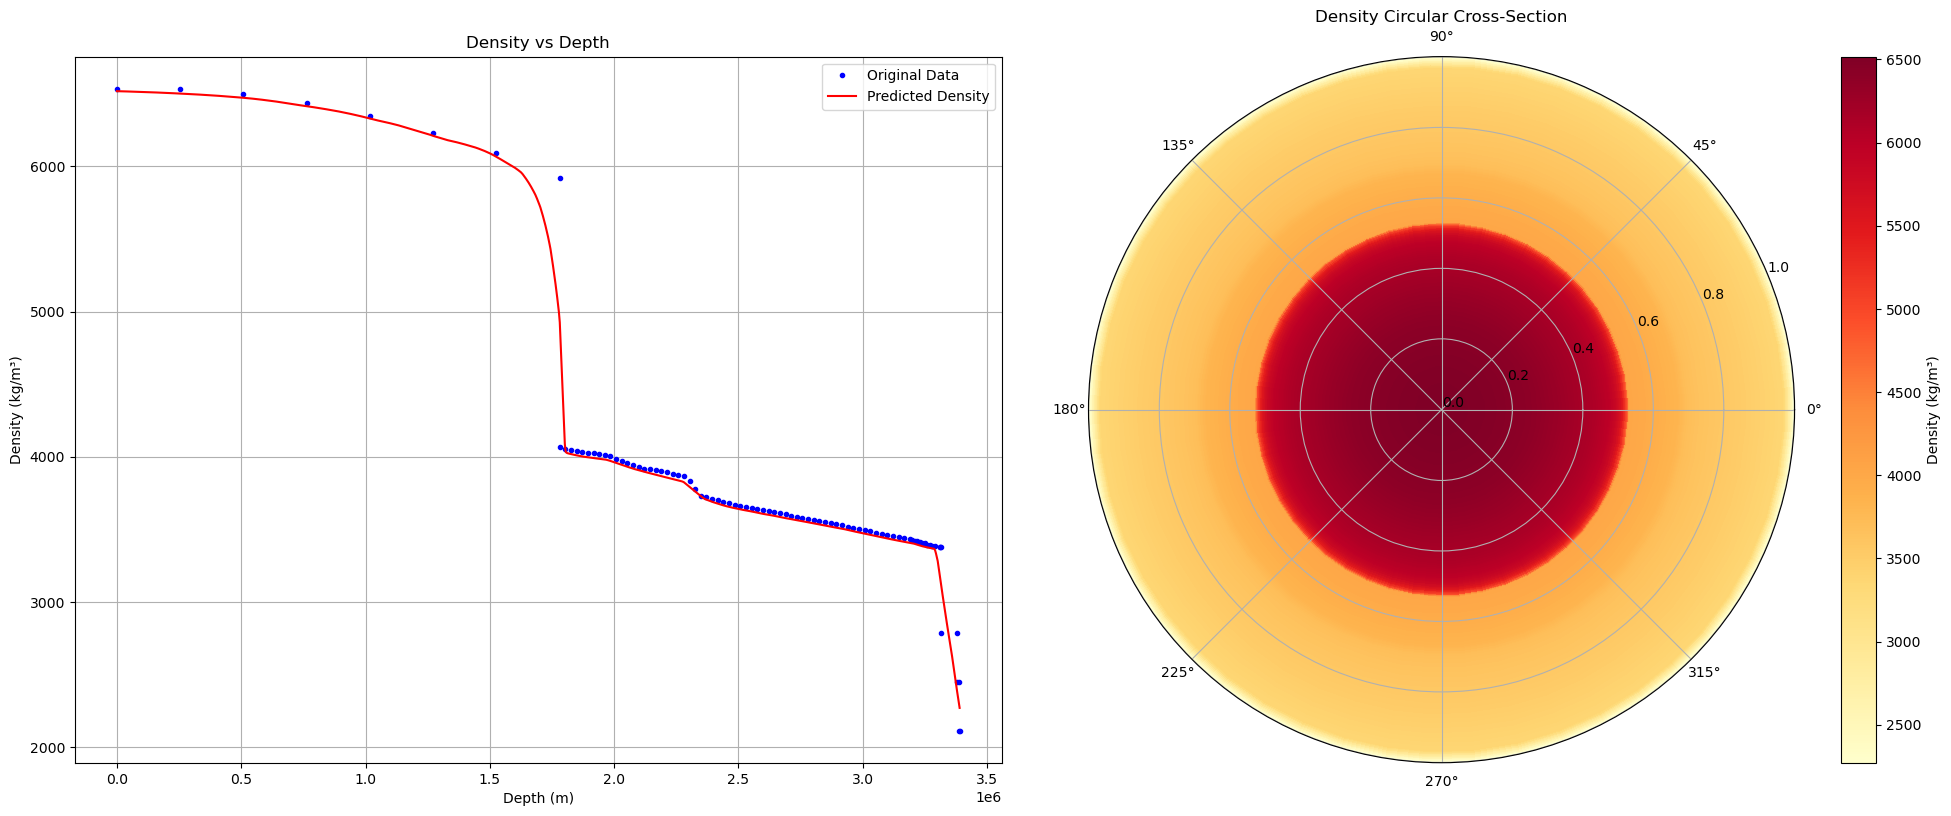

In [6]:
trained_model = load_density_model(r"module_9_data/density.pth")
predict_and_visualize_density(trained_model, depth, density)


#### **Wave Simulation Model** : 
- We define a neural network model (WaveVelocityGPNN) that maps P-wave and S-wave velocities to depth data. It uses a combination of linear layers, radial basis function (RBF) kernels, and inducing points to process input depth data and output predicted velocities. The model also incorporates a pre-trained density model to enhance its predictions and includes methods to compute partial differential equation (PDE) losses for both P-wave and S-wave velocities.
- This is a PINN (Physics informed neural network) since it use the laws of physics namely the P and S wave equation which is a PDE (partial differential equation) to compute the loss minimising the deviation from the theoretically calculated P and S waves velocities , while MSE loss minimises the deviation from the known data points from the datasets obatined. 

In [4]:
class WaveVelocityGPNN(nn.Module):
    def __init__(self, hidden_dim=128, num_inducing=32):
       super().__init__()
       self.hidden_dim = hidden_dim
       self.num_inducing = num_inducing
       self.depth_norm = 3.5e6
       self.velocity_norm = 1e4
       self.density_model = DensityGPNN()
       self.density_model.load_state_dict(torch.load(r"module_9_data/density.pth"))
       self.density_model.eval()
       self.network = nn.Sequential(
           nn.Linear(1, hidden_dim),
           nn.LayerNorm(hidden_dim),
           nn.ReLU(),
           nn.Linear(hidden_dim, hidden_dim),
           nn.LayerNorm(hidden_dim),
           nn.ReLU(),
           nn.Linear(hidden_dim, hidden_dim),
           nn.LayerNorm(hidden_dim),
           nn.ReLU()
       )
       self.inducing_points = nn.Parameter(
           torch.linspace(0, 1, num_inducing).reshape(-1, 1)
       )
       self.rbf_network = nn.Sequential(
           nn.Linear(2, hidden_dim),
           nn.ReLU(),
           nn.Linear(hidden_dim, 1),
           nn.Softplus()
       )
       self.p_output_net = nn.Sequential(
           nn.Linear(hidden_dim, hidden_dim),
           nn.LayerNorm(hidden_dim),
           nn.ReLU(),
           nn.Linear(hidden_dim, 1),
           nn.Softplus()
       )
       self.s_output_net = nn.Sequential(
           nn.Linear(hidden_dim, hidden_dim),
           nn.LayerNorm(hidden_dim),
           nn.ReLU(),
           nn.Linear(hidden_dim, 1),
           nn.Softplus()
       )

    def rbf_kernel(self, x, centers):
       x_expanded = x.unsqueeze(1)
       centers_expanded = centers.unsqueeze(0)
       pairs = torch.cat([
           x_expanded.expand(-1, centers.shape[0], -1),
           centers_expanded.expand(x.shape[0], -1, -1)
       ], dim=2)
       return self.rbf_network(pairs).squeeze(-1)

    def forward(self, depth):
       x = depth / self.depth_norm
       features = self.network(x)
       kernel_values = self.rbf_kernel(x, self.inducing_points)
       weights = torch.softmax(kernel_values, dim=-1)
       inducing_features = self.network(self.inducing_points)
       combined = torch.matmul(weights, inducing_features)
       final_features = features + combined
       vp = self.p_output_net(final_features) * self.velocity_norm
       vs = self.s_output_net(final_features) * self.velocity_norm
       return vp, vs
    def get_p_pde_loss(self, depth):
        x = depth / self.depth_norm
        vp, _ = self.forward(depth)
        pred_density = self.density_model(x * self.depth_norm)
        d2vp_dx2, d2vp_dt2 = self.compute_derivatives(x, depth, vp)
        p_pde_loss = d2vp_dx2 - torch.sqrt((MODULI_PARAMS["core"]["K"] + 2 * MODULI_PARAMS["core"]["mu"]) / pred_density)
        return p_pde_loss

    def get_s_pde_loss(self, depth):
        x = depth / self.depth_norm
        _, vs = self.forward(depth)
        pred_density = self.density_model(x * self.depth_norm)
        _, d2vs_dt2 = self.compute_derivatives(x, depth, vs)
        s_pde_loss = d2vs_dt2 - torch.sqrt(MODULI_PARAMS["core"]["mu"] / pred_density)
        return s_pde_loss

    def compute_derivatives(self, x, t, features):
        x_norm = x / self.depth_norm
        t_norm = t.float() / self.depth_norm 
        x_norm = x_norm.view(-1, 1)
        t_norm = t_norm.view(-1, 1)
        inputs = torch.cat([x_norm, t_norm], dim=1)
        inputs.requires_grad_(True)
    
        network_features = self.network(x_norm)
        features = self.p_output_net(network_features)
        grads = torch.autograd.grad(features.sum(), inputs, create_graph=True, allow_unused=True)[0]
        if grads is None:
            return torch.zeros_like(x), torch.zeros_like(x)
        du_dx = grads[:, 0:1] 
        du_dt = grads[:, 1:2]
        d2u_dx2 = torch.autograd.grad(du_dx.sum(), inputs, create_graph=True, allow_unused=True)[0]
        d2u_dx2 = d2u_dx2[:, 0:1] if d2u_dx2 is not None else torch.zeros_like(x)
        d2u_dt2 = torch.autograd.grad(du_dt.sum(), inputs, create_graph=True, allow_unused=True)[0]
        d2u_dt2 = d2u_dt2[:, 1:2] if d2u_dt2 is not None else torch.zeros_like(x)
        
        return d2u_dx2, d2u_dt2

    def rho(self, x):
       depth = x * self.depth_norm
       for layer in MODULI_PARAMS.values():
           if depth <= layer["depth"]:
               return layer["density"] * torch.ones_like(x)
   
def train_wave_model(model, data_file, epochs=5000):
    depth, _, vp, vs = prepare_data(data_file)
    optimizer = optim.Yogi(model.parameters(), lr=0.0005, betas=(0.9, 0.999), 
                            eps=1e-8, weight_decay=1e-5)
    scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=200, T_mult=2)
    criterion = nn.MSELoss()
    best_p_loss = float('inf')
    best_s_loss = float('inf')
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        optimizer.zero_grad()
        pred_vp, pred_vs = model(depth)
        p_loss = criterion(pred_vp, vp)
        s_loss = criterion(pred_vs, vs)
        
        p_pde_loss = torch.mean(torch.square(model.get_p_pde_loss(depth)))
        s_pde_loss = torch.mean(torch.square(model.get_s_pde_loss(depth)))
        total_loss = p_loss + s_loss + 0.01 * p_pde_loss + 0.01 * s_pde_loss
        if isinstance(total_loss, tuple):
            total_loss = total_loss[0]
        
        if not (torch.isnan(total_loss) or torch.isinf(total_loss)):
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            pbar.set_description(f"P-Loss: {p_loss.item():.6f}, S-Loss: {s_loss.item():.6f}, P-PDE: {p_pde_loss.item():.6f}, S-PDE: {s_pde_loss.item():.6f}")
            
            if p_loss.item() + p_pde_loss.item() < best_p_loss:
                best_p_loss = p_loss.item() + p_pde_loss.item()
                torch.save(model.state_dict(), r'module_9_data/HOSHIYAR_P.pth')
            
            if s_loss.item() + s_pde_loss.item() < best_s_loss:
                best_s_loss = s_loss.item() + s_pde_loss.item()
                torch.save(model.state_dict(), r'module_9_data/HOSHIYAR_S.pth')
    return model

In [6]:
model = WaveVelocityGPNN(hidden_dim=128, num_inducing=32)
model = train_wave_model(model, r"module_9_data\BM FILES\DWAK.txt")

P-Loss: 154088.171875, S-Loss: 162574.171875, P-PDE: 2309402.750000, S-PDE: 461880.531250: 100%|██████████| 5000/5000 [04:51<00:00, 17.16it/s]   


In [13]:
def load_and_visualize_models(data_file):
    depth, density, vp_true, vs_true = prepare_data(data_file)
    test_depths = torch.linspace(depth.min(), depth.max(), 1000).reshape(-1, 1)
    
    p_model = WaveVelocityGPNN()
    s_model = WaveVelocityGPNN()
    
    p_model.load_state_dict(torch.load(r'module_9_data\HOSHIYAR_P.pth'))
    s_model.load_state_dict(torch.load(r'module_9_data\HOSHIYAR_S.pth'))
    
    p_model.eval()
    s_model.eval()
    
    with torch.no_grad():
        pred_vp, _ = p_model(test_depths)
        _, pred_vs = s_model(test_depths)
    
    plt.figure(figsize=(20, 15))
    
    plt.subplot(2, 2, 1)
    plt.plot(depth.numpy(), vp_true.numpy(), 'b.', label='Original Data', alpha=0.5)
    plt.plot(test_depths.numpy(), pred_vp.numpy(), 'r-', label='P-Wave Simulation')
    plt.title('P-wave Velocity vs Depth')
    plt.xlabel('Depth (m)')
    plt.ylabel('Velocity (m/s)')
    plt.grid(True)
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(depth.numpy(), vs_true.numpy(), 'b.', label='Original Data', alpha=0.5)
    plt.plot(test_depths.numpy(), pred_vs.numpy(), 'r-', label='S-Wave Simulation')
    plt.title('S-wave Velocity vs Depth')
    plt.xlabel('Depth (m)')
    plt.ylabel('Velocity (m/s)')
    plt.grid(True)
    plt.legend()
    
    vp_array = pred_vp.numpy().flatten()
    vs_array = pred_vs.numpy().flatten()
    
    n_radial = 500
    n_angular = 50
    
    theta = np.linspace(0, 2*np.pi, n_angular)
    r = np.linspace(0, 1, n_radial)
    R, Theta = np.meshgrid(r, theta)
    
    vp_polar = np.interp(np.linspace(0, 1, n_radial), 
                         np.linspace(0, 1, len(vp_array)), 
                         vp_array)
    vs_polar = np.interp(np.linspace(0, 1, n_radial), 
                         np.linspace(0, 1, len(vs_array)), 
                         vs_array)
    
    vp_2d = np.tile(vp_polar, (n_angular, 1))
    vs_2d = np.tile(vs_polar, (n_angular, 1))
    
    plt.subplot(2, 2, 3, projection='polar')
    plt.pcolormesh(Theta, R, vp_2d, cmap='viridis')
    plt.title('P-wave Velocity Circular Cross-Section')
    plt.colorbar(label='P-wave Velocity (m/s)')
    
    plt.subplot(2, 2, 4, projection='polar')
    plt.pcolormesh(Theta, R, vs_2d, cmap='plasma')
    plt.title('S-wave Velocity Circular Cross-Section')
    plt.colorbar(label='S-wave Velocity (m/s)')
    
    plt.tight_layout()
    plt.show()

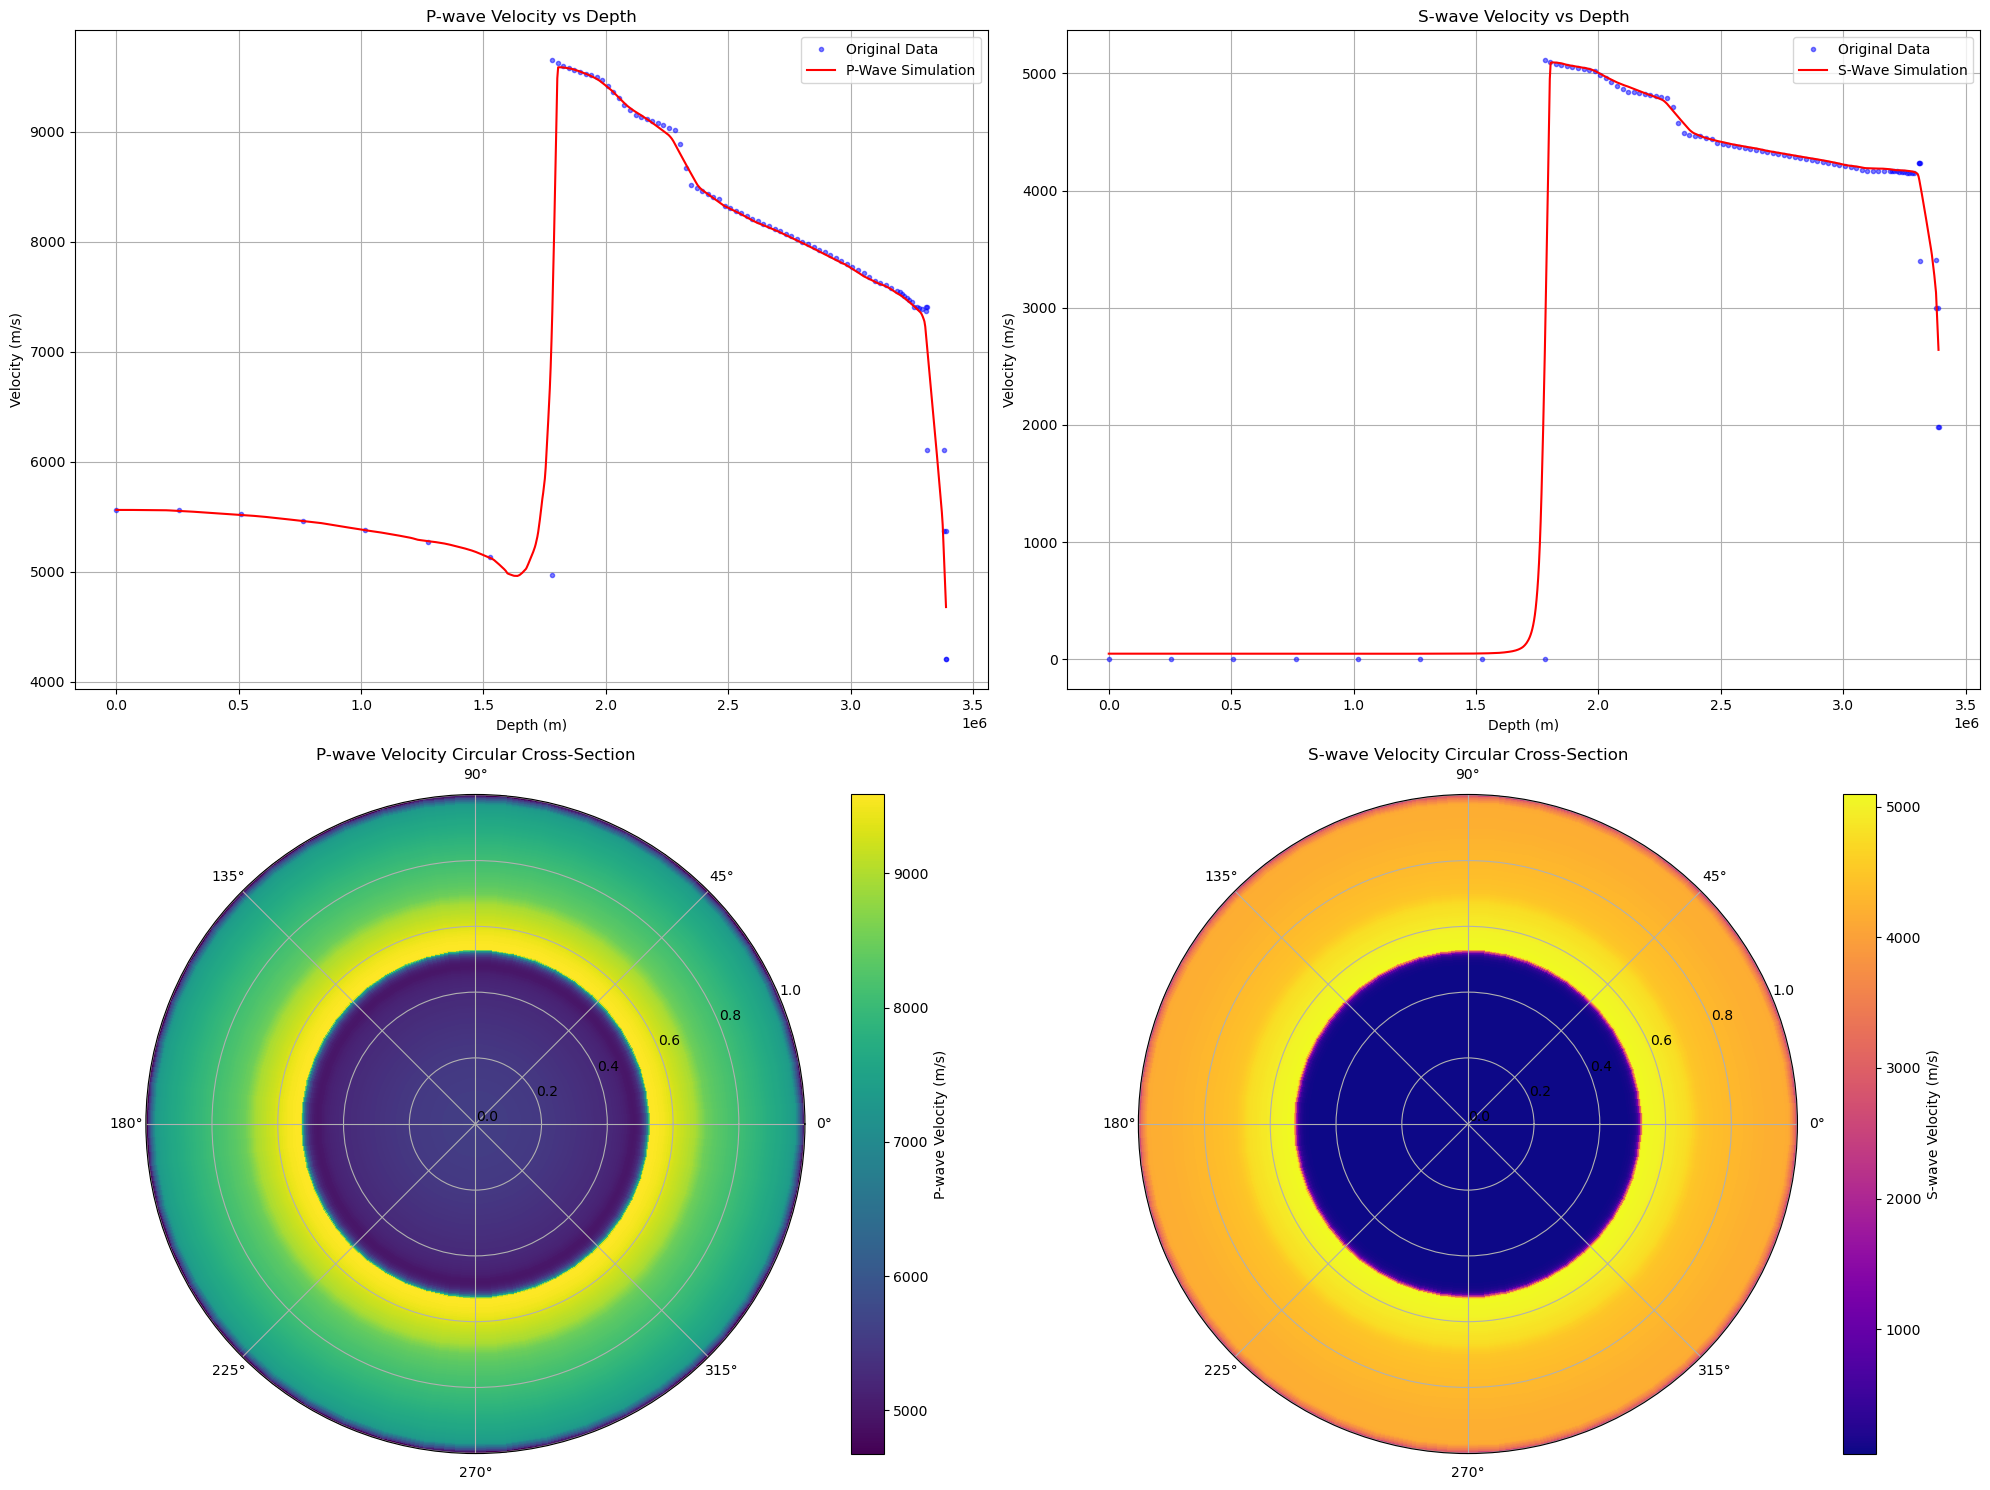

In [14]:
load_and_visualize_models(r"module_9_data\BM FILES\DWAK.txt")

#### Estimation of refraction angles and Shadow Zones : 
- **Wave Velocity and Shadow Zone Calculation** : We use the pre-trained neural network model (WaveVelocityGPNN) to predict P-wave velocities in the mantle and core of Mars. It calculates the critical angle for wave refraction at the core-mantle boundary (CMB) and determines the shadow zone, which is the region where P-waves are not detected due to refraction.
- **Visualization of Ray Paths and Shadow Zone** : The class includes a method to plot the ray paths of P-waves as they travel through Mars, illustrating the shadow zone where waves are absent. It visualizes the critical angle, incident and refraction angles, and provides a table summarizing these angles, along with the velocities in the mantle and core


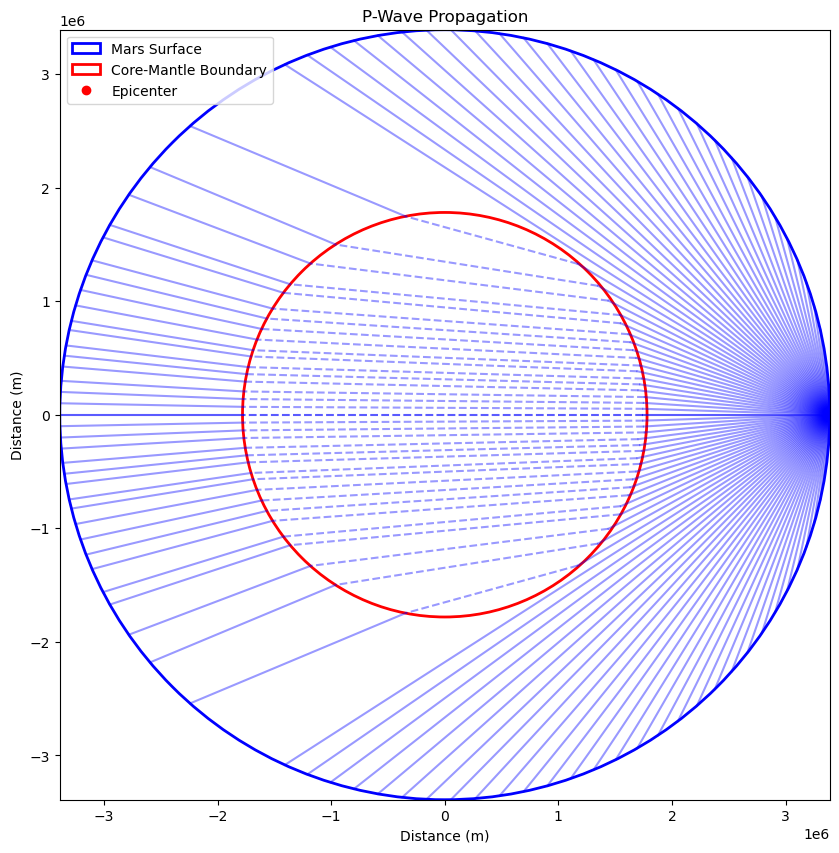

    Incident Angle (°)  Refraction Angle (°)
0             0.000000              0.000000
1             2.623872              2.005394
2             5.247744              4.009036
3             7.871616              6.009157
4            10.495488              8.003958
5            13.119360              9.991591
6            15.743233             11.970144
7            18.367105             13.937622
8            20.990977             15.891931
9            23.614849             17.830855
10           26.238721             19.752035
11           28.862593             21.652951
12           31.486465             23.530894
13           34.110337             25.382942
14           36.734209             27.205933
15           39.358081             28.996435
16           41.981954             30.750724
17           44.605826             32.464745
18           47.229698             34.134094
19           49.853570             35.753985
Critical Angle: 49.85°
Velocity in Mantle: 9572.0117187

In [7]:
class WaveAnalysis:
    def __init__(self):
        self.cmb_radius = CORE_MANTLE  
        self.mars_radius = RADIUS  
        self.model = WaveVelocityGPNN()
        self.model.load_state_dict(torch.load(r'module_9_data\HOSHIYAR_P.pth'))
        self.model.eval()

    def snells_law(self, incident_angle, v1, v2):
        sin_theta_t = (v1 / v2) * np.sin(incident_angle)  
        if abs(sin_theta_t) > 1:  
            return None
        return np.arcsin(sin_theta_t)

    def critical_angle(self, v1, v2):
        return np.arcsin(v2 / v1)

    def calculate_shadow_zone(self):
        depth_mantle = torch.tensor([[self.cmb_radius + 80000]], dtype=torch.float32)
        depth_core = torch.tensor([[self.cmb_radius]], dtype=torch.float32)

        with torch.no_grad():
            vp_mantle, _ = self.model(depth_mantle)
            vp_core, _ = self.model(depth_core)

        vp_mantle = vp_mantle.item()
        vp_core = vp_core.item()

        critical_angle = self.critical_angle(vp_mantle, vp_core)
        R = self.mars_radius
        r = self.cmb_radius
        theta_min = np.arcsin(r / R * np.sin(critical_angle))
        theta_max = np.pi - theta_min

        dist_min = R * theta_min
        dist_max = R * theta_max

        return {
            'min_angle_deg': np.degrees(theta_min),
            'max_angle_deg': np.degrees(theta_max),
            'min_distance_km': dist_min / 1000,
            'max_distance_km': dist_max / 1000,
            'critical_angle': critical_angle,
            'vp_mantle': vp_mantle,
            'vp_core': vp_core
        }

    def plot_ray_paths(self):
        shadow_info = self.calculate_shadow_zone()
        critical_angle = shadow_info['critical_angle']
        vp_mantle = shadow_info['vp_mantle']
        vp_core = shadow_info['vp_core']

        fig, ax = plt.subplots(figsize=(10, 10))
        mars_circle = plt.Circle((0, 0), self.mars_radius, fill=False, color='blue', linewidth=2, label="Mars Surface")
        core_circle = plt.Circle((0, 0), self.cmb_radius, fill=False, color='red', linewidth=2, label="Core-Mantle Boundary")
        ax.add_patch(mars_circle)
        ax.add_patch(core_circle)
        epicenter_angle = 0  
        epicenter_x = self.mars_radius * np.cos(epicenter_angle)
        epicenter_y = self.mars_radius * np.sin(epicenter_angle)
        ax.plot(epicenter_x, epicenter_y, 'ro', label="Epicenter")
        num_waves = 100  
        wave_angles = np.linspace(-np.pi , np.pi , num_waves)  

        for theta in wave_angles:
            x_outer = self.mars_radius * np.cos(epicenter_angle + theta)
            y_outer = self.mars_radius * np.sin(epicenter_angle + theta)

            chord_x = np.linspace(epicenter_x, x_outer, 100)
            chord_y = np.linspace(epicenter_y, y_outer, 100)
            chord_dist = np.sqrt(chord_x**2 + chord_y**2)
            core_contact_idx = np.where(chord_dist <= self.cmb_radius)[0]

            if len(core_contact_idx) > 0:
                core_contact_idx = core_contact_idx[0]
                x_core = chord_x[core_contact_idx]
                y_core = chord_y[core_contact_idx]
                incident_angle = np.arctan2(y_core, x_core)

                if abs(incident_angle) <= critical_angle:
                    refraction_angle = self.snells_law(incident_angle, vp_mantle, vp_core)
                    if refraction_angle is not None:
                        x_core_exit = -self.cmb_radius * np.cos(refraction_angle)
                        y_core_exit = self.cmb_radius * np.sin(refraction_angle)
                        exit_incident_angle = np.arctan2(y_core_exit, x_core_exit)  
                        refraction_exit_angle = self.snells_law(exit_incident_angle, vp_core, vp_mantle)

                        if refraction_exit_angle is not None:
                            x_final = -self.mars_radius * np.cos(refraction_exit_angle)
                            y_final = self.mars_radius * np.sin(refraction_exit_angle)
                            ax.plot([epicenter_x, x_core], [epicenter_y, y_core], 'b-', alpha=0.4)  
                            ax.plot([x_core, x_core_exit], [y_core, y_core_exit], 'b--', alpha=0.4)  
                            ax.plot([x_core_exit, x_final], [y_core_exit, y_final], 'b-', alpha=0.4)  

            else:
                ax.plot(chord_x, chord_y, 'b-', alpha=0.4)

        ax.set_xlim([-self.mars_radius, self.mars_radius])
        ax.set_ylim([-self.mars_radius, self.mars_radius])
        ax.set_aspect('equal')
        ax.grid(False)
        ax.set_title('P-Wave Propagation')
        ax.set_xlabel('Distance (m)')
        ax.set_ylabel('Distance (m)')
        ax.legend()

        plt.show()

    def generate_refraction_table(self):
        shadow_info = self.calculate_shadow_zone()
        vp_mantle = shadow_info['vp_mantle']
        vp_core = shadow_info['vp_core']
        critical_angle = np.degrees(shadow_info['critical_angle'])

        incident_angles = np.linspace(0, critical_angle, 20)
        refraction_angles = np.degrees(np.arcsin((vp_core / vp_mantle) * np.sin(np.radians(incident_angles))))

        data = {
            "Incident Angle (°)": incident_angles,
            "Refraction Angle (°)": refraction_angles
        }

        df = pd.DataFrame(data)
        print(df)
        print(f"Critical Angle: {critical_angle:.2f}°")
        print(f"Velocity in Mantle: {vp_mantle} m/s")
        print(f"Velocity in Core: {vp_core} m/s")

wave_analysis = WaveAnalysis()
shadow_info = wave_analysis.calculate_shadow_zone()
wave_analysis.plot_ray_paths()
wave_analysis.generate_refraction_table()
